In [1]:
import tensorflow as tf
import jpeg_related_functions as jrf
import multilayerCSC_ADMM as mlcsc
import numpy as np
import pickle as pkl
import datetime

In [2]:
rho = 1.
alpha_init = 1.
mu_init = 1.
b_init = 0.
lraParam = {'n_components': 3}
cmplxdtype = tf.complex128 # This should really be elsewhere.
batch_size = 8
noe_per_save = 1
num_of_saves = 2
step_size = 0.1

In [3]:
experimentpath = 'data/experiment/simpleTest/experiment1/'
def checkpointfilename(ii):
    return 'checkpoint_epoch' + str(ii) + '.ckpt'
modelfilename = 'initial_model.ckpt'
fid = open(experimentpath + 'problem_param.pckl','rb')
problem_param = pkl.load(fid)
fid.close()
data_param = problem_param['data_param']
targetSz = data_param['target_size']
qY = data_param['qY']
qUV = data_param['qUV']
strides = problem_param['stride']
fltrSz = problem_param['fltrSz']
real_dtype = data_param['dtype']
noi = problem_param['noi']
noL = problem_param['noL']
noc = problem_param['noc']
datapath = problem_param['datapath']
trainfile = problem_param['trainfile']
padding = data_param['padding']


In [4]:
cropAndMerge = mlcsc.CropPadObject(targetSz,strides,[np.asarray(ks) for ks in fltrSz],real_dtype)
paddingTuple = cropAndMerge.paddingTuple
fftSz = cropAndMerge.get_fft_size(targetSz,strides)
paddingDiff = ((padding[0][0] - paddingTuple[0][0],padding[0][1] - paddingTuple[0][1]),(padding[1][0] - paddingTuple[1][0],padding[1][1] - paddingTuple[1][1]))
assert(paddingDiff[0][0] >= 0)
assert(paddingDiff[0][1] >= 0)
assert(paddingDiff[1][0] >= 0)
assert(paddingDiff[1][1] >= 0)
print(paddingDiff)


((4, 4), (4, 4))


In [5]:
startr = paddingDiff[0][0]
startc = paddingDiff[1][0]
endr = targetSz[0] + padding[0][0] + padding[0][1] - paddingDiff[0][1]
endc = targetSz[1] + padding[1][0] + padding[1][1] - paddingDiff[1][1]
example_structure = {'highpass': tf.io.FixedLenFeature([], tf.string), 'lowpass': tf.io.FixedLenFeature([], tf.string), 'compressed': tf.io.FixedLenFeature([], tf.string),'raw': tf.io.FixedLenFeature([], tf.string)}

def restore_double(x):
    return tf.io.parse_tensor(x,real_dtype)

def _parse_image_function(example_proto):
    x = tf.io.parse_single_example(example_proto, example_structure)
    highpass = restore_double(x['highpass'])
    lowpass = restore_double(x['lowpass'])
    return ((highpass[slice(startr,endr),slice(startc,endc),slice(None)],lowpass[slice(startr,endr),slice(startc,endc),slice(None)],restore_double(x['compressed'])),restore_double(x['raw']))

raw_dataset = tf.data.TFRecordDataset([datapath + trainfile])
dataset = raw_dataset.map(_parse_image_function)
dataset_batch = dataset.batch(batch_size)


In [6]:
for (x,y) in dataset_batch:
    print(x[0].shape)
    print(x[1].shape)
    print(x[2].shape)
    print(y.shape)
    print(tf.reduce_max(tf.abs(cropAndMerge.crop(x[0]) + cropAndMerge.crop(x[1]) - x[2])))
    croppedHighpass = x[0][slice(None),slice(paddingTuple[0][0], paddingTuple[0][0] + targetSz[0]),slice(paddingTuple[1][0],paddingTuple[1][0] + targetSz[1]),slice(None)]
    croppedLowpass = x[1][slice(None),slice(paddingTuple[0][0],paddingTuple[0][0] + targetSz[0]),slice(paddingTuple[1][0],paddingTuple[1][0] + targetSz[1]),slice(None)]
    print(croppedHighpass.shape)
    print(croppedLowpass.shape)
    print(x[2].shape)
    print(tf.reduce_max(tf.abs(croppedHighpass + croppedLowpass - x[2])))
    print(tf.reduce_max(x[2]))
    print(tf.reduce_min(x[2]))
    break

(8, 66, 66, 3)
(8, 66, 66, 3)
(8, 48, 48, 3)
(8, 48, 48, 3)
tf.Tensor(2.7755575615628914e-17, shape=(), dtype=float64)
(8, 48, 48, 3)
(8, 48, 48, 3)
(8, 48, 48, 3)
tf.Tensor(2.7755575615628914e-17, shape=(), dtype=float64)
tf.Tensor(1.125205629055991, shape=(), dtype=float64)
tf.Tensor(-0.06353589012926698, shape=(), dtype=float64)


In [7]:
CSC = mlcsc.MultiLayerCSC(rho,alpha_init,mu_init,b_init,qY,qUV,cropAndMerge,fftSz,strides,problem_param['D'],lraParam,noi,noL,cmplxdtype,name='CSC')

In [8]:
highpassShape = (targetSz[0] + paddingTuple[0][0] + paddingTuple[0][1],targetSz[1] + paddingTuple[1][0] + paddingTuple[1][1],noc)
highpass = tf.keras.Input(shape=highpassShape,dtype=real_dtype)
lowpass = tf.keras.Input(shape = highpassShape,dtype = real_dtype)
compressed = tf.keras.Input(shape = (targetSz[0],targetSz[1],noc),dtype= real_dtype)
inputs = (highpass,lowpass,compressed)

reconstruction,itstats = CSC(inputs)
import post_process_grad as ppg
model = ppg.Model_PostProcess(inputs,reconstruction)

In [9]:
for (x,y) in dataset_batch:
    x_input = x
    x_output = y
    break



In [10]:
recon,itstats = CSC(x_input)
print(tf.reduce_max(recon))
print(tf.reduce_min(recon))
print(tf.reduce_mean(recon))

tf.Tensor(11.37138289035445, shape=(), dtype=float64)
tf.Tensor(-8.765268696324037, shape=(), dtype=float64)
tf.Tensor(0.428583209216592, shape=(), dtype=float64)


In [12]:
prevs,improvements,errs = itstats
x_improvements,y_improvements = improvements
v_improvements,vplusz_improvements = y_improvements
recon_err,cmprssd_recon_err,primal_err,cnstrnt_err = errs

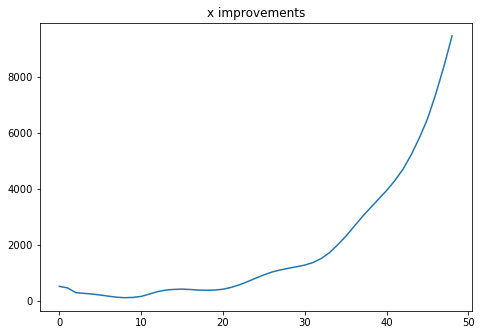

In [14]:
from matplotlib import pyplot as plot
%matplotlib inline
fig = plot.figure()
ax = fig.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(x_improvements))
y_plot = np.asarray(x_improvements)
ax.plot(x_incrments,y_plot)
ax.set_title('x improvements')

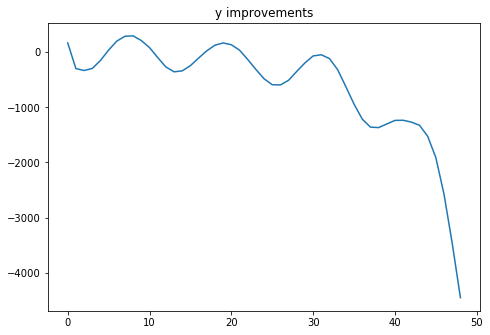

In [16]:
fig2 = plot.figure()
ax2 = fig2.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(vplusz_improvements))
y_plot = np.asarray(vplusz_improvements)
ax2.plot(x_incrments,y_plot)
ax2.set_title('y improvements')

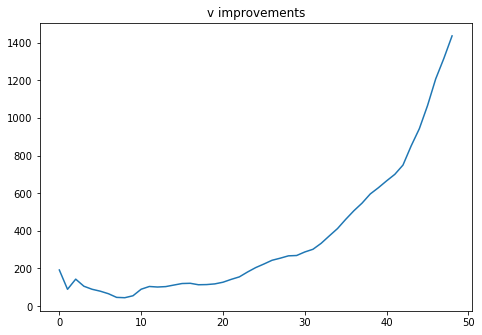

In [17]:
fig3 = plot.figure()
ax3 = fig3.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(v_improvements))
y_plot = np.asarray(v_improvements)
ax3.plot(x_incrments,y_plot)
ax3.set_title('v improvements')

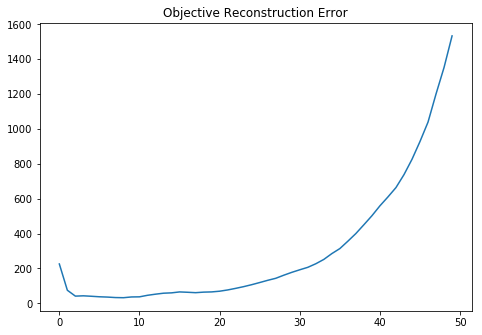

In [18]:
fig4 = plot.figure()
ax4 = fig4.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(recon_err))
y_plot = np.asarray(recon_err)
ax4.plot(x_incrments,y_plot)
ax4.set_title('Objective Reconstruction Error')

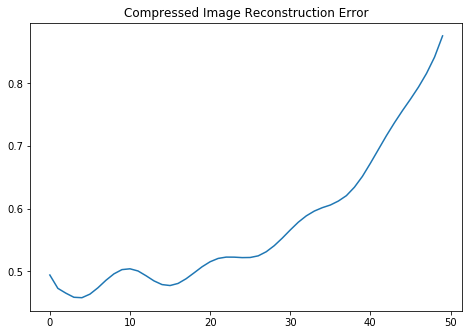

In [19]:
fig5 = plot.figure()
ax5 = fig5.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(cmprssd_recon_err))
y_plot = np.asarray(cmprssd_recon_err)
ax5.plot(x_incrments,y_plot)
ax5.set_title('Compressed Image Reconstruction Error')

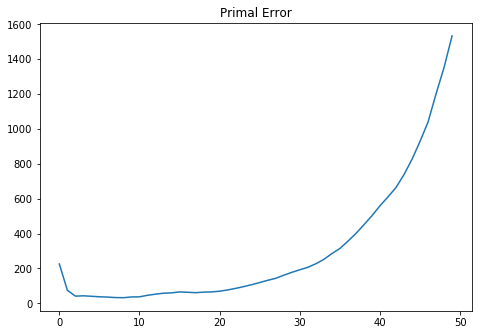

In [20]:
fig6 = plot.figure()
ax6 = fig6.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(primal_err))
y_plot = np.asarray(primal_err)
ax6.plot(x_incrments,y_plot)
ax6.set_title('Primal Error')

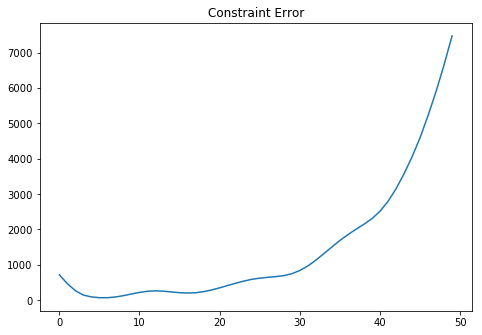

In [21]:
fig7 = plot.figure()
ax7 = fig7.add_axes([0,0,1,1])
x_incrments = np.arange(0,len(cnstrnt_err))
y_plot = np.asarray(cnstrnt_err)
ax7.plot(x_incrments,y_plot)
ax7.set_title('Constraint Error')

In [83]:
print(tf.reduce_max(x_input[0]))
print(tf.reduce_min(x_input[0]))
print(tf.reduce_max(x_input[1]))
print(tf.reduce_min(x_input[1]))
print(tf.reduce_max(x_input[2]))
print(tf.reduce_min(x_input[2]))

tf.Tensor(0.44676498581946467, shape=(), dtype=float64)
tf.Tensor(-0.43713007100573065, shape=(), dtype=float64)
tf.Tensor(0.9576848929109221, shape=(), dtype=float64)
tf.Tensor(-0.003449462903720394, shape=(), dtype=float64)
tf.Tensor(1.125205629055991, shape=(), dtype=float64)
tf.Tensor(-0.06353589012926698, shape=(), dtype=float64)


In [10]:
s = CSC.preprocess(x_input)
y,u,By,negC,itstats = CSC.init_vars(s)


In [29]:
y,u,By,itstats = CSC.solvestep(y,u,By,negC,itstats)

In [30]:
v,z = y
recon = CSC.cropAndMerge.crop(CSC.IFFT[0](v))
print(tf.reduce_max(recon))
print(tf.reduce_min(recon))
print(tf.reduce_mean(recon))

tf.Tensor(1.7192615527320552, shape=(), dtype=float64)
tf.Tensor(-1.310095666279717, shape=(), dtype=float64)
tf.Tensor(0.00030146542486767923, shape=(), dtype=float64)


In [10]:
s = CSC.preprocess(x_input)
y,u,By,negC,itstats = CSC.init_vars(s)


In [21]:
x,Ax = CSC.xstep(y,u,By,negC)
Ax_relaxed = CSC.relax(Ax,By,negC)

In [22]:
rho = CSC.rho
#if CSC.strides[0] == 2:
#    mu = CSC.updateZ[0][0].mu
#else:
mu = CSC.updateZ_lastlayer.mu
Azero,Ax = Ax_relaxed
v,z = y
Bv,Bz = By
eta,gamma = u
Dx = CSC.IFFT[0](CSC.dictObj[0].dmul(x[0]))
augLangbefore = mu/2*CSC.reconstructionTerm(CSC.IFFT[0](v),Dx) + CSC.jpegConstraint_relaxed(eta,Azero,Bv)

In [23]:
y,By = CSC.ystep(x,u,Ax_relaxed,negC)

In [24]:
v,z = y
Bv,Bz = By

augLangafter = mu/2*CSC.reconstructionTerm(CSC.IFFT[0](v),Dx) + CSC.jpegConstraint_relaxed(eta,Azero,Bv)

print(augLangbefore - augLangafter)

tf.Tensor(8872.723529993324, shape=(), dtype=float64)


In [25]:
u = CSC.ustep(u,Ax_relaxed,By,negC)

In [151]:
tf.reduce_max(tf.math.abs(x[0] - z[0]))

<tf.Tensor: shape=(), dtype=float64, numpy=1.8861385026584094e-11>

In [10]:
s = CSC.preprocess(x_input)
y,u,By,negC,itstats = CSC.init_vars(s)


In [77]:
x,Ax = CSC.xstep(y,u,By,negC)
Ax_relaxed = CSC.relax(Ax,By,negC)

In [78]:
rho = CSC.rho
#if CSC.strides[0] == 2:
#    mu = CSC.updateZ[0][0].mu
#else:
mu = CSC.updateZ_lastlayer.mu
Azero,Ax = Ax_relaxed
v,z = y
Bv,Bz = By
eta,gamma = u
Dx = CSC.IFFT[0](CSC.dictObj[0].dmul(x[0]))
augLangbefore = mu/2*CSC.reconstructionTerm(CSC.IFFT[0](v),Dx) + CSC.jpegConstraint_relaxed(eta,Bv,negC)

In [79]:
import util
vplus_LF,Bv = CSC.updatev((CSC.cropAndMerge.crop(tf.squeeze(Dx,axis=-1)) + CSC.cropAndMerge.crop(x_input[1]),eta,negC[1]))
v_small = vplus_LF - CSC.cropAndMerge.crop(x_input[1])
v = CSC.cropAndMerge.merge((v_small,tf.squeeze(Dx,axis=-1)))
augLangafter = mu/2*CSC.reconstructionTerm(v,tf.squeeze(Dx,axis=-1)) + CSC.jpegConstraint_relaxed(eta,Bv,negC)
print(augLangbefore - augLangafter)
y = (CSC.FFT[0](util.addDim(v)),z)
By = (Bv,Bz)

tf.Tensor(110.98279148314543, shape=(), dtype=float64)


In [80]:
u = CSC.ustep(u,Ax_relaxed,By,negC)

In [23]:
print(rho)
print(CSC.updatev.rho)
print(CSC.updatev.mu)
print(mu)

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>


In [11]:
s = CSC.preprocess(x_input)
y,u,By,negC,itstats = CSC.init_vars(s)


In [12]:
x,Ax = CSC.xstep(y,u,By,negC)

In [43]:
Ax_relaxed = CSC.relax(Ax,By,negC)

In [44]:
beforeyupdate = CSC.evaluateRelaxedLagrangian(x,y,u,Ax_relaxed,By,negC)
#beforeyupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
y,By = CSC.ystep(x,u,Ax_relaxed,negC)
#afteryupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
afteryupdate = CSC.evaluateRelaxedLagrangian(x,y,u,Ax_relaxed,By,negC)

print('y-step improvement: ',beforeyupdate - afteryupdate)

y-step improvement:  tf.Tensor(132.39678583763612, shape=(), dtype=float64)


In [45]:

u = CSC.ustep(u,Ax_relaxed,By,negC)

In [46]:
beforexupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
#print('u-step ascent: ',beforexupdate - afteryupdate)
x,Ax = CSC.xstep(y,u,By,negC)
afterxupdate = CSC.evaluateLagrangian(x,y,u,By,negC)

print('x-step improvement: ',beforexupdate - afterxupdate)

x-step improvement:  tf.Tensor(153.9968656518622, shape=(), dtype=float64)


In [47]:
v,z = y
recon = CSC.cropAndMerge.crop(CSC.IFFT[0](v))
print(tf.reduce_max(recon))
print(tf.reduce_min(recon))
print(tf.reduce_mean(recon))

tf.Tensor(1.499960972546149, shape=(), dtype=float64)
tf.Tensor(-1.0223701895955746, shape=(), dtype=float64)
tf.Tensor(-0.00026397253758130663, shape=(), dtype=float64)


In [18]:
xprev = x[0]

In [24]:
print(tf.reduce_max(tf.abs(x[0] - xprev)))

tf.Tensor(78.00138303332352, shape=(), dtype=float64)


In [82]:
recon2 = CSC.cropAndMerge.crop(CSC.IFFT[0](CSC.dictObj[0].dmul(x[0])))
print(tf.reduce_max(recon2))
print(tf.reduce_min(recon2))
print(tf.reduce_mean(recon2))

tf.Tensor(1.7186674165345042, shape=(), dtype=float64)
tf.Tensor(-1.891466022264373, shape=(), dtype=float64)
tf.Tensor(0.00015348225783739947, shape=(), dtype=float64)


In [10]:
s = CSC.preprocess(x_input)
y,u,By,negC,itstats = CSC.init_vars(s)

In [11]:

x,Ax = CSC.xstep(y,u,By,negC)


In [68]:
Ax_relaxed = CSC.relax(Ax,By,negC)

In [69]:
beforeyupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
y,By = CSC.ystep(x,u,Ax_relaxed,negC)
afteryupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
print('y-update improvement: ',beforeyupdate - afteryupdate)

y-update improvement:  tf.Tensor(4075.768058284011, shape=(), dtype=float64)


In [70]:
lagrangbefore = CSC.evaluateLagrangian(x,y,u,By,negC)
eta,gamma = u
AzeroplusC,Ax_layers = Ax_relaxed
Bv,z = By
for ii in range(CSC.noL):
    gamma[ii] = CSC.updateGamma(gamma[ii],z[ii],Ax_layers[ii],ii)
    u = (eta,gamma)
    lagrangafter = CSC.evaluateLagrangian(x,y,u,By,negC)
    print('layer[' + str(ii) + '] gamma ascent: ', lagrangafter - lagrangbefore)
    lagrangbefore = lagrangafter
eta = CSC.updateEta(eta,AzeroplusC,Bv)
u = (eta,gamma)
lagrangafter = CSC.evaluateLagrangian(x,y,u,By,negC)
print('eta ascent: ',lagrangafter - lagrangbefore)

layer[0] gamma ascent:  tf.Tensor(0.00321943627204746, shape=(), dtype=float64)
eta ascent:  tf.Tensor(-1284.5795792535064, shape=(), dtype=float64)


In [67]:
beforexupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
x,Ax = CSC.xstep(y,u,By,negC)
afterxupdate = CSC.evaluateLagrangian(x,y,u,By,negC)
print('x-update improvement: ',beforexupdate - afterxupdate)

x-update improvement:  tf.Tensor(1413.5530663121026, shape=(), dtype=float64)


In [21]:
print(tf.reduce_max(x_input[2] - CSC.cropAndMerge.crop(CSC.cropAndMerge.merge((x_input[2],x_input[0])))))

tf.Tensor(0.0, shape=(), dtype=float64)


In [22]:
print(tf.reduce_max(x_input[0] - CSC.cropAndMerge.merge((x_input[2],x_input[0]))))

tf.Tensor(0.03007777523421025, shape=(), dtype=float64)


In [23]:
print(tf.reduce_max(x_input[1] - CSC.cropAndMerge.merge((x_input[2],x_input[1]))))

tf.Tensor(0.3684579105100836, shape=(), dtype=float64)


In [26]:
print(tf.reduce_max(CSC.cropAndMerge.crop(x_input[0]) + CSC.cropAndMerge.crop(x_input[1]) - x_input[2]))

tf.Tensor(2.7755575615628914e-17, shape=(), dtype=float64)
